1. Попробуйте видоизменить параметры разобранной на уроке двухслойной нейронной сети таким образом, чтобы улучшить ее точность.
2. Проведите анализ — что приводит к ухудшению точности нейронной сети?
3. Что приводит к увеличению ее точности?

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler


In [2]:
def to_one_hot(Y):
    n_col = np.max(Y) + 1
    binarized = np.zeros((len(Y), n_col))
    for i in range(len(Y)):
        binarized[i, Y[i]] = 1
    return binarized

In [3]:
def show_res(errors, metrics):
    plt.figure(figsize=(16, 5))
    plt.plot(errors)
    plt.xlabel('Обучение')
    plt.ylabel('Ошибка')
    plt.show()

    plt.figure(figsize=(16, 5))
    plt.plot(metrics)
    plt.xlabel('Количество итераций')
    plt.ylabel('Accuracy')
    plt.show()

In [4]:
class NNet:
    
    def __init__(self,
                 hidden_func: str,
                 activation_func: str,
                 hidden_func_deriv: str,
                 activation_func_deriv: str):
        
        self.hidden_func = hidden_func
        self.activation_func = activation_func
        self.hidden_func_deriv = hidden_func_deriv
        self.activation_func_deriv = activation_func_deriv
        
    
    def sigmoid(self, x):
        x = np.clip(x, a_min=-500, a_max=500)
        return 1 / (1 + np.exp(-x))
    
    
    def sigmoid_deriv(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))
    
    
    def tangens(self, x):
        x = np.clip(x, a_min=-500, a_max=500)
        return 2 * self.sigmoid(2 * x) - 1
    
    
    def tangens_deriv(self, x):
        return -self.tangens(x) ** 2 + 1
    
    
    
    def fit(self, 
            X_train: np.ndarray,
            y_train: np.ndarray,
            epoch_num: int,
            neuron_num: int,
            learning_rate: float,
            seed: int=42):
            
        np.random.seed(seed)

        self.w0 = np.random.random((X_train.shape[1], neuron_num))
        self.w1 = np.random.random((neuron_num, y_train.shape[1]))

        for epoch in range(epoch_num):
            layer0 = X_train
            layer1 = eval(f'self.{self.hidden_func}')(np.dot(layer0, self.w0))
            layer2 = eval(f'self.{self.activation_func}')(np.dot(layer1, self.w1))

            layer2_error = layer2 - y_train
            layer2_grad = layer2_error * eval(f'self.{self.activation_func_deriv}')(layer2)

            layer1_error = layer2_grad.dot(self.w1.T)
            layer1_grad = layer1_error * eval(f'self.{self.hidden_func_deriv}')(layer1)

            self.w1 -= layer1.T.dot(layer2_grad) * learning_rate
            self.w0 -= layer0.T.dot(layer1_grad) * learning_rate
                
        
    def predict(self, X_test):
        
        layer0 = X_test
        layer1 = eval(f'self.{self.hidden_func}')(np.dot(layer0, self.w0))
        layer2 = eval(f'self.{self.activation_func}')(np.dot(layer1, self.w1))
        return np.argmax(layer2, axis=1)
    
    
    def grid_search(self,
                   epoch_list,
                   neuron_list,
                   lr_list,
                   X_train,
                   y_train,
                   X_test,
                   y_test):
        
        result = pd.DataFrame(columns=['hidden_func',
                                       'activation_func',
                                       'learnig_rate',
                                       'epoch_number',
                                       'neuron_number',
                                       'accuracy_train',
                                       'accuracy_test'])
        
        for rate in lr_list:
            for epoch in epoch_list:
                for neuron in neuron_list:
                    self.fit(X_train, y_train, epoch_num=epoch, neuron_num=neuron, learning_rate=rate)
                    preds_train = self.predict(X_train)
                    preds_test = self.predict(X_test)
                    
                    result = result.append({'hidden_func': self.hidden_func,
                                            'activation_func': self.activation_func,
                                            'learnig_rate': rate,
                                            'epoch_number': epoch,
                                            'neuron_number': neuron,
                                            'accuracy_train': (preds_train == np.argmax(y_train, axis=1)).sum() / preds_train.shape[0] * 100,
                                            'accuracy_test': (preds_test == np.argmax(y_test, axis=1)).sum() / preds_test.shape[0] * 100}, ignore_index=True)
        return result

(1797, 64)


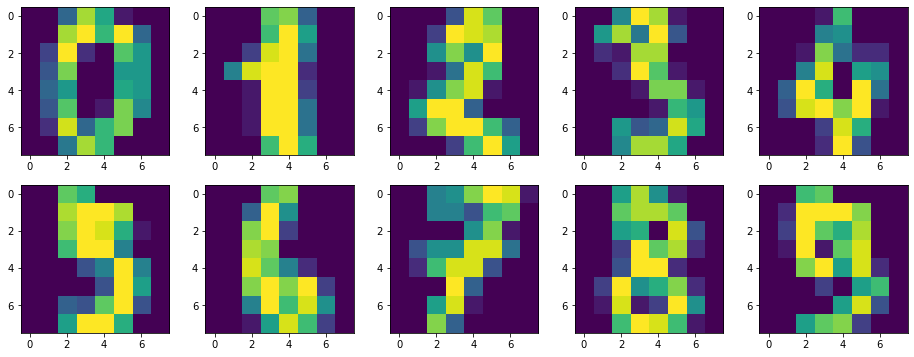

In [5]:
X, y = load_digits(return_X_y=True)
print(X.shape)
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i,:].reshape([8, 8]))

In [6]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
y = y.flatten()
y = to_one_hot(y)
display(y, y.shape)

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]])

(1797, 10)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
X_train.shape, X_test.shape

((1203, 64), (594, 64))

In [8]:
net_sig = NNet('sigmoid', 'sigmoid', 'sigmoid_deriv', 'sigmoid_deriv')

In [9]:
epoch_list = [10**i for i in range(2, 5)]
neuron_list = [10*i for i in range(1, 4)]
lr_list = [10**(-i) for i in range(1, 3)]

In [10]:
%%time
res_sig = net_sig.grid_search(epoch_list=epoch_list,
                              neuron_list=neuron_list,
                              lr_list=lr_list,
                              X_train=X_train,
                              y_train=y_train,
                              X_test=X_test,
                              y_test=y_test)

Wall time: 2min 36s


In [11]:
res_sig

,hidden_func,activation_func,learnig_rate,epoch_number,neuron_number,accuracy_train,accuracy_test
0,sigmoid,sigmoid,0.10,100,10,62.094763,61.279461
1,sigmoid,sigmoid,0.10,100,20,73.150457,74.074074
2,sigmoid,sigmoid,0.10,100,30,75.062344,77.104377
3,sigmoid,sigmoid,0.10,1000,10,86.367415,85.521886
4,sigmoid,sigmoid,0.10,1000,20,89.858687,89.393939
5,sigmoid,sigmoid,0.10,1000,30,92.601829,89.393939
6,sigmoid,sigmoid,0.10,10000,10,85.868662,84.175084
7,sigmoid,sigmoid,0.10,10000,20,92.019950,89.562290
8,sigmoid,sigmoid,0.10,10000,30,97.256858,92.087542
9,sigmoid,sigmoid,0.01,100,10,76.309227,76.430976


In [12]:
net_tan = NNet('tangens', 'tangens', 'tangens_deriv', 'tangens_deriv')

In [13]:
%%time
res_tan = net_tan.grid_search(epoch_list=epoch_list,
                              neuron_list=neuron_list,
                              lr_list=lr_list,
                              X_train=X_train,
                              y_train=y_train,
                              X_test=X_test,
                              y_test=y_test)

Wall time: 2min 49s


In [14]:
res_tan

,hidden_func,activation_func,learnig_rate,epoch_number,neuron_number,accuracy_train,accuracy_test
0,tangens,tangens,0.10,100,10,10.473815,9.427609
1,tangens,tangens,0.10,100,20,10.058188,9.595960
2,tangens,tangens,0.10,100,30,10.058188,9.595960
3,tangens,tangens,0.10,1000,10,17.705736,17.676768
4,tangens,tangens,0.10,1000,20,33.333333,33.838384
5,tangens,tangens,0.10,1000,30,10.058188,9.595960
6,tangens,tangens,0.10,10000,10,10.058188,9.595960
7,tangens,tangens,0.10,10000,20,69.409809,69.696970
8,tangens,tangens,0.10,10000,30,10.473815,10.101010
9,tangens,tangens,0.01,100,10,10.058188,9.595960


In [15]:
net_mix = NNet('sigmoid', 'tangens', 'sigmoid_deriv', 'tangens_deriv')

In [16]:
%%time
res_mix = net_mix.grid_search(epoch_list=epoch_list,
                              neuron_list=neuron_list,
                              lr_list=lr_list,
                              X_train=X_train,
                              y_train=y_train,
                              X_test=X_test,
                              y_test=y_test)

Wall time: 2min 32s


In [17]:
res_mix

,hidden_func,activation_func,learnig_rate,epoch_number,neuron_number,accuracy_train,accuracy_test
0,sigmoid,tangens,0.10,100,10,10.058188,9.59596
1,sigmoid,tangens,0.10,100,20,10.058188,9.59596
2,sigmoid,tangens,0.10,100,30,10.058188,9.59596
3,sigmoid,tangens,0.10,1000,10,10.058188,9.59596
4,sigmoid,tangens,0.10,1000,20,10.058188,9.59596
5,sigmoid,tangens,0.10,1000,30,10.058188,9.59596
6,sigmoid,tangens,0.10,10000,10,10.058188,9.59596
7,sigmoid,tangens,0.10,10000,20,10.058188,9.59596
8,sigmoid,tangens,0.10,10000,30,10.058188,9.59596
9,sigmoid,tangens,0.01,100,10,10.058188,9.59596


Из полученных результатов видно, что нормально справилась только сетка с сигмоидами на обоих слоях.
Точнее всего отработала версия с 30 нейронами, 1000 эпохами и скоростью 0,01.
Сравнивая показатели, можно сказать, что увеличению точности способствует умешьшение скорости обучения и увеличение количества нейронов. Увеличение же количества эпох не дает видимого результата после определенного количества.